In [284]:
import plotly.express as px
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report


Aggregate Data Sets

In [285]:
dataTemp = []
files = ["SSDP_1.csv","SSDP_135.csv", "SSDP_109.csv", "SSDP_12.csv"]
r = range(135)
for i in files:
    dataTemp.append(pd.read_csv(f"C:\\Projects\\MlFinalProj\\MlFinalProject\\DataSet\CSV\\11.SSDP\\{i}", low_memory=True))
    print(f"read {i} into memory")

df = pd.concat(dataTemp)
print(df.shape)

read SSDP_1.csv into memory
read SSDP_135.csv into memory
read SSDP_109.csv into memory
read SSDP_12.csv into memory
(200000, 254)


Label analysis

In [286]:
print(df["Label"].unique())
print(df["Label"].value_counts())
fig = px.bar(df["Label"].value_counts())
fig.show()

['Normal' 'SSDP']
Normal    115348
SSDP       84652
Name: Label, dtype: int64


In [287]:
print(df.columns)

Index(['frame.encap_type', 'frame.len', 'frame.number', 'frame.time',
       'frame.time_delta', 'frame.time_delta_displayed', 'frame.time_epoch',
       'frame.time_relative', 'radiotap.channel.flags.cck',
       'radiotap.channel.flags.ofdm',
       ...
       'tls.app_data_proto',
       'tls.compress_certificate.compressed_certificate_message.length',
       'tls.connection_id', 'tls.handshake.extension.type',
       'tls.handshake.extensions_key_share_group',
       'tls.handshake.session_ticket_length', 'tls.handshake.version',
       'tls.record.content_type', 'tls.record.version', 'Label'],
      dtype='object', length=254)


Null analysis

In [288]:
df.dropna(axis=1, how="all", inplace=True)
nulls = df.isna()
print(df.shape)

(200000, 202)


In [289]:
nonNullCols = []
for col in nulls.columns:
    if len(nulls[col].unique()) == 1 and nulls[col].unique()[0] == False:
       nonNullCols.append(col)
       
nulls.drop(nonNullCols, axis=1, inplace=True)

nullRatios = np.asarray([nulls[c].value_counts()[True] / nulls[c].shape[0] for c in nulls], dtype=float)
nullFilt = np.array([x > 0.5 for x in nullRatios])
colswithvals = np.array(nulls.columns[[not x for x in nullFilt]])
colswithvals = np.concatenate([colswithvals, nonNullCols])
print(f"Cols with greater then 50% values: {colswithvals}")
print(f'Count: {len(colswithvals)}')

Cols with greater then 50% values: ['wlan.bssid' 'wlan.da' 'wlan.sa' 'wlan.seq' 'wlan.ta' 'llc' 'ip.dst'
 'ip.proto' 'ip.src' 'ip.ttl' 'ip.version' 'frame.encap_type' 'frame.len'
 'frame.number' 'frame.time' 'frame.time_delta'
 'frame.time_delta_displayed' 'frame.time_epoch' 'frame.time_relative'
 'radiotap.channel.flags.cck' 'radiotap.channel.flags.ofdm'
 'radiotap.channel.freq' 'radiotap.dbm_antsignal' 'radiotap.length'
 'radiotap.present.tsft' 'radiotap.rxflags' 'radiotap.timestamp.ts'
 'wlan.duration' 'wlan.fc.ds' 'wlan.fc.frag' 'wlan.fc.order'
 'wlan.fc.moredata' 'wlan.fc.protected' 'wlan.fc.pwrmgt' 'wlan.fc.type'
 'wlan.fc.retry' 'wlan.fc.subtype' 'wlan.ra' 'wlan_radio.duration'
 'wlan_radio.channel' 'wlan_radio.data_rate' 'wlan_radio.frequency'
 'wlan_radio.signal_dbm' 'wlan_radio.phy' 'Label']
Count: 45


Ip analysis

In [290]:
ip = ["ip.dst","ip.proto","ip.src","ip.ttl","ip.version"]

ipOnly = df.drop(df.columns.difference(ip), axis=1)
print(ipOnly.shape)
for c in ipOnly.columns:
    print(ipOnly[c].isna().value_counts())

ipOnly.dropna(axis=0, how="any", inplace=True)

print(ipOnly.columns)

(200000, 5)
False    129001
True      70999
Name: ip.dst, dtype: int64
False    129001
True      70999
Name: ip.proto, dtype: int64
False    129001
True      70999
Name: ip.src, dtype: int64
False    129001
True      70999
Name: ip.ttl, dtype: int64
False    129059
True      70941
Name: ip.version, dtype: int64
Index(['ip.dst', 'ip.proto', 'ip.src', 'ip.ttl', 'ip.version'], dtype='object')


#### Deleting the rows from the DataFrame with NA values from the IP columns

In [291]:
print("df shape before: ", df.shape)
for i in ipOnly.columns:
    df.dropna(subset=[i], axis=0, how="any", inplace=True)

print("df shape after:", df.shape)

df shape before:  (200000, 202)
df shape after: (129001, 202)


In [292]:
pd.set_option('display.max_columns', None)
df.head(10)

,frame.encap_type,frame.len,frame.number,frame.time,frame.time_delta,frame.time_delta_displayed,frame.time_epoch,frame.time_relative,radiotap.channel.flags.cck,radiotap.channel.flags.ofdm,radiotap.channel.freq,radiotap.datarate,radiotap.dbm_antsignal,radiotap.length,radiotap.mactime,radiotap.present.tsft,radiotap.rxflags,radiotap.timestamp.ts,wlan.duration,wlan.analysis.kck,wlan.analysis.kek,wlan.bssid,wlan.country_info.fnm,wlan.country_info.code,wlan.da,wlan.fc.ds,wlan.fc.frag,wlan.fc.order,wlan.fc.moredata,wlan.fc.protected,wlan.fc.pwrmgt,wlan.fc.type,wlan.fc.retry,wlan.fc.subtype,wlan.fixed.beacon,wlan.fixed.capabilities.ess,wlan.fixed.capabilities.ibss,wlan.fixed.reason_code,wlan.fixed.timestamp,wlan.ra,wlan_radio.duration,wlan.rsn.ie.gtk.key,wlan.rsn.ie.igtk.key,wlan.sa,wlan.seq,wlan.ssid,wlan.ta,wlan.tag,wlan.tag.length,wlan_radio.channel,wlan_radio.data_rate,wlan_radio.end_tsf,wlan_radio.frequency,wlan_radio.signal_dbm,wlan_radio.start_tsf,wlan_radio.phy,wlan_radio.timestamp,wlan.rsn.capabilities.mfpc,wlan_rsna_eapol.keydes.msgnr,wlan_rsna_eapol.keydes.data,wlan_rsna_eapol.keydes.data_len,wlan_rsna_eapol.keydes.key_info.key_mic,wlan_rsna_eapol.keydes.nonce,eapol.keydes.key_len,eapol.keydes.replay_counter,eapol.len,eapol.type,llc,arp,arp.hw.type,arp.proto.type,arp.hw.size,arp.proto.size,arp.opcode,arp.src.hw_mac,arp.src.proto_ipv4,arp.dst.hw_mac,arp.dst.proto_ipv4,ip.dst,ip.proto,ip.src,ip.ttl,ip.version,data.data,data.len,tcp.ack,tcp.ack_raw,tcp.analysis,tcp.analysis.flags,tcp.analysis.retransmission,tcp.analysis.rto_frame,tcp.checksum,tcp.checksum.status,tcp.flags.syn,tcp.dstport,tcp.flags.ack,tcp.flags.fin,tcp.flags.push,tcp.flags.reset,tcp.option_len,tcp.payload,tcp.seq,tcp.seq_raw,tcp.srcport,tcp.time_delta,tcp.time_relative,udp.dstport,udp.srcport,udp.length,udp.payload,udp.time_relative,udp.time_delta,nbns,nbss.type,nbss.length,smb.access.generic_execute,smb.access.generic_read,smb.access.generic_write,smb.flags.notify,smb.flags.response,smb.flags2.nt_error,smb.flags2.sec_sig,smb.mid,smb.server_component,smb.pid.high,smb.tid,smb2.auth_frame,smb2.buffer_code,smb2.cmd,smb2.fid,smb2.header_len,smb2.msg_id,smb2.pid,smb2.protocol_id,smb2.sesid,smb2.session_flags,smb2.tid,dhcp,dhcp.id,dhcp.ip.client,dhcp.ip.relay,dhcp.ip.server,mdns,dns,dns.a,dns.count.add_rr,dns.count.answers,dns.count.auth_rr,dns.count.labels,dns.count.queries,dns.flags.authoritative,dns.flags.checkdisable,dns.flags.opcode,dns.flags.response,dns.id,dns.qry.name,dns.qry.name.len,dns.resp.name,dns.resp.ttl,dns.resp.len.1,dns.retransmit_request,dns.retransmit_response,dns.time,ssdp,http.connection,http.content_length,http.content_type,http.date,http.file_data,http.host,http.last_modified,http.location,http.request.full_uri,http.request.line,http.request.method,http.request.uri.path,http.request.uri.query,http.request.uri.query.parameter,http.request.version,http.request_in,http.response.code,http.response.code.desc,http.response.line,http.response.phrase,http.response.version,http.response_for.uri,http.referer,http.time,http.server,json.value.string,json.key,tls.alert_message.desc,tls.alert_message.level,tls.app_data_proto,tls.compress_certificate.compressed_certificate_message.length,tls.handshake.extension.type,tls.handshake.extensions_key_share_group,tls.handshake.session_ticket_length,tls.handshake.version,tls.record.content_type,tls.record.version,Label
1,23,170,50002,Dec 13- 2020 20:55:27.014771000 GTB Standard Time,0.000095,0.000095,1607885727,194.715447,0,1,5180,NaN,-96,64,NaN,0-0-0,0x00000000,719218845,48,NaN,NaN,0c:9d:92:54:fe:34,NaN,NaN,94:e9:79:82:c5:77,0x00000002,0,0,0,1,0,2,0,8,NaN,NaN,NaN,NaN,NaN,94:e9:79:82:c5:77,51,NaN,NaN,0c:9d:92:54:fe:30,920.0,NaN,0c:9d:92:54:fe:34,NaN,NaN,36,78.000,NaN,5180,-30,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,llc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.168.2.41,6,162.125.66.14,57,4,NaN,NaN,1326268,3311914000,1,1.0,NaN,NaN,0x00004f3b,2,0,37880,1,0,0,0,10,NaN,4185,2008319236,443,0.007536,2.58039,N

#### Further Null Analysis

In [293]:
# finding columns with NaN values and ratio of NaN values to the total
nan_col = df.columns[df.isna().any()].tolist()
print("\nNaN column count: ", len(nan_col))
print("Total columns:", len(df.columns))
nan_col_ratio = df.isna().mean().tolist()


nan_column = {nan_col[i]: nan_col_ratio[i] for i in range(len(nan_col))}
print("Columns with NaN:")
print(nan_column)
print("\n")

# get columns with ratio of NaN values more than 50%
useless_col = dict((k, v) for k, v in nan_column.items() if v >= 0.5)
print("Columns with more than 50% NaN values: ")
print(useless_col)
print(f'\nNumber of useless columns {len(useless_col)}')
print(f'Column with the least ratio: {min(useless_col, key=useless_col.get)}')

#print (df.isin([' ','NULL',0]).mean())


NaN column count:  157
Total columns: 202
Columns with NaN:
{'radiotap.datarate': 0.0, 'radiotap.mactime': 0.0, 'wlan.analysis.kck': 0.0, 'wlan.analysis.kek': 0.0, 'wlan.country_info.fnm': 0.0, 'wlan.country_info.code': 0.0, 'wlan.fixed.beacon': 0.0, 'wlan.fixed.capabilities.ess': 0.0, 'wlan.fixed.capabilities.ibss': 0.0, 'wlan.fixed.reason_code': 0.0, 'wlan.fixed.timestamp': 0.0, 'wlan.rsn.ie.gtk.key': 0.9993255866233595, 'wlan.rsn.ie.igtk.key': 0.0, 'wlan.ssid': 0.0, 'wlan.tag': 0.9993255866233595, 'wlan.tag.length': 0.0, 'wlan_radio.end_tsf': 0.0, 'wlan_radio.start_tsf': 0.0, 'wlan_radio.timestamp': 0.0, 'wlan.rsn.capabilities.mfpc': 1.0, 'wlan_rsna_eapol.keydes.msgnr': 1.0, 'wlan_rsna_eapol.keydes.data': 0.0, 'wlan_rsna_eapol.keydes.data_len': 1.0, 'wlan_rsna_eapol.keydes.key_info.key_mic': 1.0, 'wlan_rsna_eapol.keydes.nonce': 0.0, 'eapol.keydes.key_len': 0.0, 'eapol.keydes.replay_counter': 0.0, 'eapol.len': 0.0, 'eapol.type': 0.0, 'arp': 0.0, 'arp.hw.type': 0.0, 'arp.proto.type':

In [294]:
# dropping the columns with more than 50% null values

df = df.dropna(thresh=df.shape[0]*0.5,axis=1)
#df = df.dropna(thresh=df.shape[0]*0.5, axis=1, subset=df.columns.difference(ip))

print("New df shape:", df.shape)
df.head(10)

New df shape: (129001, 57)


,frame.encap_type,frame.len,frame.number,frame.time,frame.time_delta,frame.time_delta_displayed,frame.time_epoch,frame.time_relative,radiotap.channel.flags.cck,radiotap.channel.flags.ofdm,radiotap.channel.freq,radiotap.dbm_antsignal,radiotap.length,radiotap.present.tsft,radiotap.rxflags,radiotap.timestamp.ts,wlan.duration,wlan.bssid,wlan.da,wlan.fc.ds,wlan.fc.frag,wlan.fc.order,wlan.fc.moredata,wlan.fc.protected,wlan.fc.pwrmgt,wlan.fc.type,wlan.fc.retry,wlan.fc.subtype,wlan.ra,wlan_radio.duration,wlan.sa,wlan.seq,wlan.ta,wlan_radio.channel,wlan_radio.data_rate,wlan_radio.frequency,wlan_radio.signal_dbm,wlan_radio.phy,llc,ip.dst,ip.proto,ip.src,ip.ttl,ip.version,udp.dstport,udp.srcport,udp.length,udp.payload,udp.time_relative,udp.time_delta,ssdp,http.host,http.request.full_uri,http.request.line,http.request.method,http.request.version,Label
1,23,170,50002,Dec 13- 2020 20:55:27.014771000 GTB Standard Time,0.000095,0.000095,1607885727,194.715447,0,1,5180,-96,64,0-0-0,0x00000000,719218845,48,0c:9d:92:54:fe:34,94:e9:79:82:c5:77,0x00000002,0,0,0,1,0,2,0,8,94:e9:79:82:c5:77,51,0c:9d:92:54:fe:30,920.0,0c:9d:92:54:fe:34,36,78.000,5180,-30,8,llc,192.168.2.41,6,162.125.66.14,57,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal
5,23,1550,50006,Dec 13- 2020 20:55:27.015709000 GTB Standard Time,0.000687,0.000687,1607885727,194.716385,0,1,5180,-96,64,0-0-0,0x00000000,719219218,48,0c:9d:92:54:fe:34,50:3e:aa:e3:1f:be,0x00000002,0,0,0,1,0,2,0,8,50:3e:aa:e3:1f:be,108,0c:9d:92:54:fe:30,911.0,0c:9d:92:54:fe:34,36,173.333,5180,-30,8,llc,192.168.2.190,6,151.101.17.140,58,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal
6,23,1550,50007,Dec 13- 2020 20:55:27.015726000 GTB Standard Time,0.000017,0.000017,1607885727,194.716402,0,1,5180,-96,64,0-0-0,0x00000000,719219218,48,0c:9d:92:54:fe:34,50:3e:aa:e3:1f:be,0x00000002,0,0,0,1,0,2,0,8,50:3e:aa:e3:1f:be,108,0c:9d:92:54:fe:30,912.0,0c:9d:92:54:fe:34,36,173.333,5180,-30,8,llc,192.168.2.190,6,151.101.17.140,58,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal
7,23,1550,50008,Dec 13- 2020 20:55:27.015729000 GTB Standard Time,0.000003,0.000003,1607885727,194.716405,0,1,5180,-96,64,0-0-0,0x00000000,719219218,48,0c:9d:92:54:fe:34,50:3e:aa:e3:1f:be,0x00000002,0,0,0,1,0,2,0,8,50:3e:aa:e3:1f:be,108,0c:9d:92:54:fe:30,913.0,0c:9d:92:54:fe:34,36,173.333,5180,-30,8,llc,192.168.2.190,6,151.101.17.140,58,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal
8,23,1550,50009,Dec 13- 2020 20:55:27.015735000 GTB Standard Time,0.000006,0.000006,1607885727,194.716411,0,1,5180,-96,64,0-0-0,0x00000000,719219218,48,0c:9d:92:54:fe:34,50:3e:aa:e3:1f:be,0x00000002,0,0,0,1,0,2,0,8,50:3e:aa:e3:1f:be,108,0c:9d:92:54:fe:30,914.0,0c:9d:92:54:fe:34,36,173.333,5180,-30,8,llc,192.168.2.190,6,151.101.17.140,58,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal
9,23,1550,50010,Dec 13- 2020 20:55:27.015738000 GTB Standard Time,0.000003,0.000003,1607885727,194.716414,0,1,5180,-96,64,0-0-0,0x00000000,719219218,48,0c:9d:92:54:fe:34,50:3e:aa:e3:1f:be,0x00000002,0,0,0,1,0,2,0,8,50:3e:aa:e3:1f:be,108,0c:9d:92:54:fe:30,915.0,0c:9d:92:54:fe:34,36,173.333,5180,-30,8,llc,192.168.2.190,6,151.101.17.140,58,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal
10,23,1550,50011,Dec 13- 2020 20:55:27.015741000 GTB Standard Time,0.000003,0.000003,1607885727,194.716417,0,1,5180,-96,64,0-0-0,0x00000000,719219218,48,0c:9d:92:54:fe:34,50:3e:aa:e3:1f:be,0x00000002,0,0,0,1,0,2,0,8,50:3e:aa:e3:1f:be,108,0c:9d:92:54:fe:30,916.0,0c:9d:92:54:fe:34,36,173.333,5180,-30,8,llc,192.168.2.190,6,151.101.17.140,58,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal
11,23,1550,50012,Dec 13- 2020 20:55:27.015745000 GTB Standard Time,0.000004,0.000004,1607885727,194.716421,0,1,5180,-96,64,0-0-0,0x00000000,719219218,48,0c:9d:92:54:fe:34,50:3e:aa:e3:1f:be,0x00000002,0,0,0,1,0,2,0,8,50:3e:aa:e3:1f:be,108,0c:9d:92:54:fe:30,917.0,0c:9d:92:54:fe:34,36,173.333,5180,-30,8,llc,192.168.2.190,6,151.101.17.140,58,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [295]:
#### replacing the left over NaN values with 0 or unknown
import warnings
warnings.filterwarnings('ignore')
## checking if we havent dropped IP data
# for col in df.columns:
#     if "ip" in col:
#         print(col)
# print("\n")
cnt_num = 0
cnt = 0
non_num_feature = []
for col in df.columns:
    if (df[col].dtypes == "int64") or (df[col].dtypes == "float64") or ("udp" in col) :
        #print("number col: ", col, df[col].dtypes)
        cnt_num += 1
        df[col] = df[col].fillna(0)
    else:
        #print("string col:", col, df[col].dtypes)
        cnt += 1
        non_num_feature.append(col)
        df[col] = df[col].fillna('Unknown')

print("Numeric count and non numeric count: ",cnt_num, cnt)
print("Non numeric columns: ", non_num_feature)
df.head(10)

Numeric count and non numeric count:  35 22
Non numeric columns:  ['frame.time', 'radiotap.present.tsft', 'radiotap.rxflags', 'wlan.bssid', 'wlan.da', 'wlan.fc.ds', 'wlan.ra', 'wlan.sa', 'wlan.ta', 'llc', 'ip.dst', 'ip.proto', 'ip.src', 'ip.ttl', 'ip.version', 'ssdp', 'http.host', 'http.request.full_uri', 'http.request.line', 'http.request.method', 'http.request.version', 'Label']


,frame.encap_type,frame.len,frame.number,frame.time,frame.time_delta,frame.time_delta_displayed,frame.time_epoch,frame.time_relative,radiotap.channel.flags.cck,radiotap.channel.flags.ofdm,radiotap.channel.freq,radiotap.dbm_antsignal,radiotap.length,radiotap.present.tsft,radiotap.rxflags,radiotap.timestamp.ts,wlan.duration,wlan.bssid,wlan.da,wlan.fc.ds,wlan.fc.frag,wlan.fc.order,wlan.fc.moredata,wlan.fc.protected,wlan.fc.pwrmgt,wlan.fc.type,wlan.fc.retry,wlan.fc.subtype,wlan.ra,wlan_radio.duration,wlan.sa,wlan.seq,wlan.ta,wlan_radio.channel,wlan_radio.data_rate,wlan_radio.frequency,wlan_radio.signal_dbm,wlan_radio.phy,llc,ip.dst,ip.proto,ip.src,ip.ttl,ip.version,udp.dstport,udp.srcport,udp.length,udp.payload,udp.time_relative,udp.time_delta,ssdp,http.host,http.request.full_uri,http.request.line,http.request.method,http.request.version,Label
1,23,170,50002,Dec 13- 2020 20:55:27.014771000 GTB Standard Time,0.000095,0.000095,1607885727,194.715447,0,1,5180,-96,64,0-0-0,0x00000000,719218845,48,0c:9d:92:54:fe:34,94:e9:79:82:c5:77,0x00000002,0,0,0,1,0,2,0,8,94:e9:79:82:c5:77,51,0c:9d:92:54:fe:30,920.0,0c:9d:92:54:fe:34,36,78.000,5180,-30,8,llc,192.168.2.41,6,162.125.66.14,57,4,0,0,0,0,0,0,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Normal
5,23,1550,50006,Dec 13- 2020 20:55:27.015709000 GTB Standard Time,0.000687,0.000687,1607885727,194.716385,0,1,5180,-96,64,0-0-0,0x00000000,719219218,48,0c:9d:92:54:fe:34,50:3e:aa:e3:1f:be,0x00000002,0,0,0,1,0,2,0,8,50:3e:aa:e3:1f:be,108,0c:9d:92:54:fe:30,911.0,0c:9d:92:54:fe:34,36,173.333,5180,-30,8,llc,192.168.2.190,6,151.101.17.140,58,4,0,0,0,0,0,0,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Normal
6,23,1550,50007,Dec 13- 2020 20:55:27.015726000 GTB Standard Time,0.000017,0.000017,1607885727,194.716402,0,1,5180,-96,64,0-0-0,0x00000000,719219218,48,0c:9d:92:54:fe:34,50:3e:aa:e3:1f:be,0x00000002,0,0,0,1,0,2,0,8,50:3e:aa:e3:1f:be,108,0c:9d:92:54:fe:30,912.0,0c:9d:92:54:fe:34,36,173.333,5180,-30,8,llc,192.168.2.190,6,151.101.17.140,58,4,0,0,0,0,0,0,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Normal
7,23,1550,50008,Dec 13- 2020 20:55:27.015729000 GTB Standard Time,0.000003,0.000003,1607885727,194.716405,0,1,5180,-96,64,0-0-0,0x00000000,719219218,48,0c:9d:92:54:fe:34,50:3e:aa:e3:1f:be,0x00000002,0,0,0,1,0,2,0,8,50:3e:aa:e3:1f:be,108,0c:9d:92:54:fe:30,913.0,0c:9d:92:54:fe:34,36,173.333,5180,-30,8,llc,192.168.2.190,6,151.101.17.140,58,4,0,0,0,0,0,0,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Normal
8,23,1550,50009,Dec 13- 2020 20:55:27.015735000 GTB Standard Time,0.000006,0.000006,1607885727,194.716411,0,1,5180,-96,64,0-0-0,0x00000000,719219218,48,0c:9d:92:54:fe:34,50:3e:aa:e3:1f:be,0x00000002,0,0,0,1,0,2,0,8,50:3e:aa:e3:1f:be,108,0c:9d:92:54:fe:30,914.0,0c:9d:92:54:fe:34,36,173.333,5180,-30,8,llc,192.168.2.190,6,151.101.17.140,58,4,0,0,0,0,0,0,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Normal
9,23,1550,50010,Dec 13- 2020 20:55:27.015738000 GTB Standard Time,0.000003,0.000003,1607885727,194.716414,0,1,5180,-96,64,0-0-0,0x00000000,719219218,48,0c:9d:92:54:fe:34,50:3e:aa:e3:1f:be,0x00000002,0,0,0,1,0,2,0,8,50:3e:aa:e3:1f:be,108,0c:9d:92:54:fe:30,915.0,0c:9d:92:54:fe:34,36,173.333,5180,-30,8,llc,192.168.2.190,6,151.101.17.140,58,4,0,0,0,0,0,0,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Normal
10,23,1550,50011,Dec 13- 2020 20:55:27.015741000 GTB Standard Time,0.000003,0.000003,1607885727,194.716417,0,1,5180,-96,64,0-0-0,0x00000000,719219218,48,0c:9d:92:54:fe:34,50:3e:aa:e3:1f:be,0x00000002,0,0,0,1,0,2,0,8,50:3e:aa:e3:1f:be,108,0c:9d:92:54:fe:30,916.0,0c:9d:92:54:fe:34,36,173.333,5180,-30,8,llc,192.168.2.190,6,151.101.17.140,58,4,0,0,0,0,0,0,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Normal
11,23,1550,50012,Dec 13- 2020 20:55:27.015745000 GTB Standard Time,0.000004,0.000004,1607885727,194.716421,0,1,5180,-96,64,0-0-0,0x00000000,719219218,48,0c:9d:92:54:fe:34,50:3e:aa:e3:1f:be,0x00000002,0,0,0,1,0,2,0,8,50:3e:aa:e3:1f:be,108,0c:9d:92:54:fe:30,917.0,0c:9d:92:54:fe:34,36,173.333,5180,

In [296]:
def check_feature_type(df):
    cnt_num = 0
    cnt = 0
    global non_num_feature
    non_num_feature = []
    global num_feature
    num_feature = []
    for col in df.columns:
        if (df[col].dtypes == "int64") or (df[col].dtypes == "float64"):
            cnt_num += 1
            num_feature.append(col)
        else:
            #print("string col:", col, df[col].dtypes)
            cnt += 1
            non_num_feature.append(col)

    print("Numeric features: " + str(cnt_num) + " ; Non-numeric features: " + str(cnt))
    print("Non numeric columns: ", non_num_feature)
    
    return num_feature, non_num_feature

In [297]:
df[non_num_feature].head(10)

,frame.time,radiotap.present.tsft,radiotap.rxflags,wlan.bssid,wlan.da,wlan.fc.ds,wlan.ra,wlan.sa,wlan.ta,llc,ip.dst,ip.proto,ip.src,ip.ttl,ip.version,ssdp,http.host,http.request.full_uri,http.request.line,http.request.method,http.request.version,Label
1,Dec 13- 2020 20:55:27.014771000 GTB Standard Time,0-0-0,0x00000000,0c:9d:92:54:fe:34,94:e9:79:82:c5:77,0x00000002,94:e9:79:82:c5:77,0c:9d:92:54:fe:30,0c:9d:92:54:fe:34,llc,192.168.2.41,6,162.125.66.14,57,4,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Normal
5,Dec 13- 2020 20:55:27.015709000 GTB Standard Time,0-0-0,0x00000000,0c:9d:92:54:fe:34,50:3e:aa:e3:1f:be,0x00000002,50:3e:aa:e3:1f:be,0c:9d:92:54:fe:30,0c:9d:92:54:fe:34,llc,192.168.2.190,6,151.101.17.140,58,4,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Normal
6,Dec 13- 2020 20:55:27.015726000 GTB Standard Time,0-0-0,0x00000000,0c:9d:92:54:fe:34,50:3e:aa:e3:1f:be,0x00000002,50:3e:aa:e3:1f:be,0c:9d:92:54:fe:30,0c:9d:92:54:fe:34,llc,192.168.2.190,6,151.101.17.140,58,4,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Normal
7,Dec 13- 2020 20:55:27.015729000 GTB Standard Time,0-0-0,0x00000000,0c:9d:92:54:fe:34,50:3e:aa:e3:1f:be,0x00000002,50:3e:aa:e3:1f:be,0c:9d:92:54:fe:30,0c:9d:92:54:fe:34,llc,192.168.2.190,6,151.101.17.140,58,4,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Normal
8,Dec 13- 2020 20:55:27.015735000 GTB Standard Time,0-0-0,0x00000000,0c:9d:92:54:fe:34,50:3e:aa:e3:1f:be,0x00000002,50:3e:aa:e3:1f:be,0c:9d:92:54:fe:30,0c:9d:92:54:fe:34,llc,192.168.2.190,6,151.101.17.140,58,4,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Normal
9,Dec 13- 2020 20:55:27.015738000 GTB Standard Time,0-0-0,0x00000000,0c:9d:92:54:fe:34,50:3e:aa:e3:1f:be,0x00000002,50:3e:aa:e3:1f:be,0c:9d:92:54:fe:30,0c:9d:92:54:fe:34,llc,192.168.2.190,6,151.101.17.140,58,4,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Normal
10,Dec 13- 2020 20:55:27.015741000 GTB Standard Time,0-0-0,0x00000000,0c:9d:92:54:fe:34,50:3e:aa:e3:1f:be,0x00000002,50:3e:aa:e3:1f:be,0c:9d:92:54:fe:30,0c:9d:92:54:fe:34,llc,192.168.2.190,6,151.101.17.140,58,4,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Normal
11,Dec 13- 2020 20:55:27.015745000 GTB Standard Time,0-0-0,0x00000000,0c:9d:92:54:fe:34,50:3e:aa:e3:1f:be,0x00000002,50:3e:aa:e3:1f:be,0c:9d:92:54:fe:30,0c:9d:92:54:fe:34,llc,192.168.2.190,6,151.101.17.140,58,4,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Normal
12,Dec 13- 2020 20:55:27.015748000 GTB Standard Time,0-0-0,0x00000000,0c:9d:92:54:fe:34,50:3e:aa:e3:1f:be,0x00000002,50:3e:aa:e3:1f:be,0c:9d:92:54:fe:30,0c:9d:92:54:fe:34,llc,192.168.2.190,6,151.101.17.140,58,4,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Normal
13,Dec 13- 2020 20:55:27.015751000 GTB Standard Time,0-0-0,0x00000000,0c:9d:92:54:fe:34,50:3e:aa:e3:1f:be,0x00000002,50:3e:aa:e3:1f:be,0c:9d:92:54:fe:30,0c:9d:92:54:fe:34,llc,192.168.2.190,6,151.101.17.140,58,4,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Normal


#### Converting IP and MAC address information from string to int

In [298]:
import ipaddress
import re

ipv4_addr_features = ['ip.src', 'ip.dst']

# removing rows with non IP address format and then convering those IPs to integer values using ipaddress
for col in ipv4_addr_features:
    df = df[df[col].str.contains("^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}$", regex=True) == True]

for col in ipv4_addr_features:
  df[col] = df[col].apply(lambda x: int(ipaddress.IPv4Address(x)))

print("df shape after dropping non IPv4 rows: ", df.shape)

df shape after dropping non IPv4 rows:  (128693, 57)


In [299]:
mac_addr_features = ['wlan.bssid','wlan.da', 'wlan.ra', 'wlan.sa', 'wlan.ta']

# converting  MAC addresses in the wlan features to int
def mac_to_int(mac):
    mac = str(mac)
    res = re.match('^((?:(?:[0-9a-f]{2}):){5}[0-9a-f]{2})$', mac.lower())
    if res is None:
        raise ValueError(f'invalid mac address: {mac}')
    return int(res.group(0).replace(':', ''), 16)

for col in mac_addr_features:
  df[col] = df[col].apply(lambda x: mac_to_int(x))


In [300]:
udp_feaures = ['udp.dstport', 'udp.srcport', 'udp.length', 'udp.time_delta', 'ip.version']

for col in udp_feaures:
    df[col] = df[col].astype('float64')

In [301]:
check_feature_type(df)

Numeric features: 41 ; Non-numeric features: 16
Non numeric columns:  ['frame.time', 'radiotap.present.tsft', 'radiotap.rxflags', 'wlan.fc.ds', 'llc', 'ip.proto', 'ip.ttl', 'udp.payload', 'udp.time_relative', 'ssdp', 'http.host', 'http.request.full_uri', 'http.request.line', 'http.request.method', 'http.request.version', 'Label']


(['frame.encap_type',
  'frame.len',
  'frame.number',
  'frame.time_delta',
  'frame.time_delta_displayed',
  'frame.time_epoch',
  'frame.time_relative',
  'radiotap.channel.flags.cck',
  'radiotap.channel.flags.ofdm',
  'radiotap.channel.freq',
  'radiotap.dbm_antsignal',
  'radiotap.length',
  'radiotap.timestamp.ts',
  'wlan.duration',
  'wlan.bssid',
  'wlan.da',
  'wlan.fc.frag',
  'wlan.fc.order',
  'wlan.fc.moredata',
  'wlan.fc.protected',
  'wlan.fc.pwrmgt',
  'wlan.fc.type',
  'wlan.fc.retry',
  'wlan.fc.subtype',
  'wlan.ra',
  'wlan_radio.duration',
  'wlan.sa',
  'wlan.seq',
  'wlan.ta',
  'wlan_radio.channel',
  'wlan_radio.data_rate',
  'wlan_radio.frequency',
  'wlan_radio.signal_dbm',
  'wlan_radio.phy',
  'ip.dst',
  'ip.src',
  'ip.version',
  'udp.dstport',
  'udp.srcport',
  'udp.length',
  'udp.time_delta'],
 ['frame.time',
  'radiotap.present.tsft',
  'radiotap.rxflags',
  'wlan.fc.ds',
  'llc',
  'ip.proto',
  'ip.ttl',
  'udp.payload',
  'udp.time_relative',


In [302]:
print(num_feature)

['frame.encap_type', 'frame.len', 'frame.number', 'frame.time_delta', 'frame.time_delta_displayed', 'frame.time_epoch', 'frame.time_relative', 'radiotap.channel.flags.cck', 'radiotap.channel.flags.ofdm', 'radiotap.channel.freq', 'radiotap.dbm_antsignal', 'radiotap.length', 'radiotap.timestamp.ts', 'wlan.duration', 'wlan.bssid', 'wlan.da', 'wlan.fc.frag', 'wlan.fc.order', 'wlan.fc.moredata', 'wlan.fc.protected', 'wlan.fc.pwrmgt', 'wlan.fc.type', 'wlan.fc.retry', 'wlan.fc.subtype', 'wlan.ra', 'wlan_radio.duration', 'wlan.sa', 'wlan.seq', 'wlan.ta', 'wlan_radio.channel', 'wlan_radio.data_rate', 'wlan_radio.frequency', 'wlan_radio.signal_dbm', 'wlan_radio.phy', 'ip.dst', 'ip.src', 'ip.version', 'udp.dstport', 'udp.srcport', 'udp.length', 'udp.time_delta']


Noticed that wlan.bssid has the same MAC address in all rows - basic service set identifier (BSSID). THis is the MAC address of the Access Point.

#### Encoding Labels + Train-test split + Scaling
For data containing IP features

Only for Numeric Features

In [303]:
from copy import copy, deepcopy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, StandardScaler

encoder = LabelEncoder()

Y = df["Label"]
#X = df.loc[: ,df.columns != 'Label']
X = df[num_feature]

no_ip_num_features = deepcopy(num_feature)

no_ip_num_features.remove("ip.dst")
no_ip_num_features.remove("ip.src")
no_ip_num_features.remove("ip.version")
X_no_ip = df[no_ip_num_features]


X_one_feat = df[["frame.len"]]

encoded_Y = encoder.fit_transform(Y)
print(encoder.classes_)

train_data, test_data, train_labels , test_labels = train_test_split(X, encoded_Y, test_size = 0.2)
no_ip_train_data, no_ip_test_data, no_ip_train_labels , no_ip_test_labels = train_test_split(X_no_ip, encoded_Y, test_size = 0.2)
one_feat_train, one_feat_test_data, one_feat_train_labels , one_feat_test_labels = train_test_split(X_one_feat, encoded_Y, test_size = 0.2)
print(one_feat_test_data.shape)

print("Train data shape:" , train_data.shape)
print("Test data shape: ", test_data.shape)

print("No Ip Train data shape:" , no_ip_train_data.shape)
print("No Ip Test data shape: ", no_ip_test_data.shape)

scaler=StandardScaler()
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

no_ip_scaler=StandardScaler()
no_ip_scaler.fit(no_ip_train_data)
no_ip_scaled_train_data = no_ip_scaler.transform(no_ip_train_data)
no_ip_scaled_test_data = no_ip_scaler.transform(no_ip_test_data)

['Normal' 'SSDP']
(25739, 1)
Train data shape: (102954, 41)
Test data shape:  (25739, 41)
No Ip Train data shape: (102954, 38)
No Ip Test data shape:  (25739, 38)


#### Need to convert data to categorical values before performing PCA - So far able to prune NaN columns and replace leftover NaN with 0 or unknown

## PCA Analysis

PCA on unscaled data
k = 2 ; Variance = 0.9832290684559192
k = 3 ; Variance = 0.9988278270615468
k = 4 ; Variance = 0.9999999999136931
k = 5 ; Variance = 0.9999999999861829
k = 10 ; Variance = 1.0000000000000442
k = 20 ; Variance = 0.9999999999999519
k = 30 ; Variance = 0.9999999999998721
k = 40 ; Variance = 0.9999999999999999




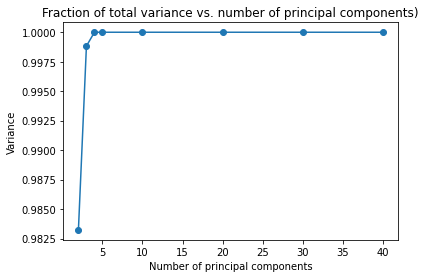

In [304]:
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA

def PCA_(k, data):

  total_var = []
  for i in range(len(k)):
    pca = PCA(n_components=k[i])
    pca.fit(data)
    var_components = pca.explained_variance_ratio_
    print("k = "+ str(k[i]) + " ; Variance = "+ str(np.sum(var_components)))
    total_var.append(np.sum(var_components))


  # plotting
  print("\n")
  plt.plot(k, total_var, marker = 'o')
  plt.title('Fraction of total variance vs. number of principal components)') 
  plt.xlabel("Number of principal components")
  plt.ylabel("Variance")

n_components = [ 2, 3, 4, 5, 10, 20, 30, 40]
print("PCA on unscaled data")
PCA_(n_components, train_data)



PCA on Scaled data
k = 2 ; Variance = 0.4515675655631595
k = 3 ; Variance = 0.5504822325209071
k = 4 ; Variance = 0.6179977809825035
k = 5 ; Variance = 0.6835852817457109
k = 10 ; Variance = 0.864167020128262
k = 20 ; Variance = 0.9965932210821358
k = 30 ; Variance = 0.9999999999999986
k = 40 ; Variance = 1.0




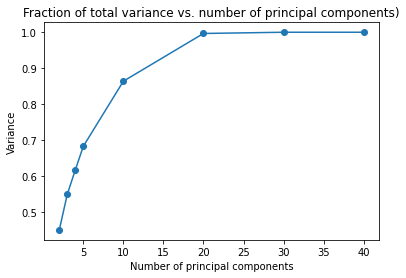

In [305]:
print("PCA on Scaled data")
PCA_(n_components, scaled_train_data)

In [306]:
# Helper func - Accuracy and error
def accuracy_scaled(model):
    y_preds= model.predict(scaled_test_data)
    return metrics.accuracy_score(test_labels, y_preds)

def accuracy_nonscaled(model):
    y_preds= model.predict(test_data)
    return metrics.accuracy_score(test_labels, y_preds)

def error_scaled(model):
    y_preds= model.predict(scaled_test_data)
    return metrics.zero_one_loss(test_labels, y_preds)

def error_nonscaled(model):
    y_preds= model.predict(test_data)
    return metrics.zero_one_loss(test_labels, y_preds)

    

In [314]:
# more sophisticated metrics:
def generate_and_display_classification_rep(model, data, y_true):
    print(np.bincount(y_true))
    
    ypred = model.predict(data)
    classRep = classification_report(y_true, ypred)
    #print(classRep)
    return classRep

#### Classification Algorithms in ML

In [308]:
# Logistic Regression
lr_scaled=LogisticRegression()
lr_scaled.fit(scaled_train_data, train_labels)
print("Scaled data model accuracy:", accuracy_scaled(lr_scaled))
print("Scaled data model error:", error_scaled(lr_scaled))
generate_and_display_classification_rep(lr_scaled, scaled_test_data, test_labels)

lr=LogisticRegression()
lr.fit(train_data, train_labels)
print("Model accuracy", accuracy_nonscaled(lr))
print("Model error:", error_nonscaled(lr))
generate_and_display_classification_rep(lr, scaled_test_data, test_labels)


Scaled data model accuracy: 0.9999611484517658
Scaled data model error: 3.8851548234242195e-05
Model accuracy 1.0
Model error: 0.0


'              precision    recall  f1-score   support\n\n           0       1.00      0.82      0.90      8857\n           1       0.91      1.00      0.95     16882\n\n    accuracy                           0.94     25739\n   macro avg       0.96      0.91      0.93     25739\nweighted avg       0.94      0.94      0.94     25739\n'

In [315]:
# Decision Tree Algorithm

dt_scaled=DecisionTreeClassifier(random_state=17)
dt_scaled.fit(scaled_train_data, train_labels)
print("Scaled data model accuracy", accuracy_scaled(dt_scaled))
print("Scaled data model error:", error_scaled(dt_scaled))
classUnscaled = generate_and_display_classification_rep(dt_scaled, scaled_test_data, test_labels)
#print(classUnscaled)

dt=DecisionTreeClassifier(random_state=17)
dt.fit(train_data, train_labels)
print("Model accuracy", accuracy_nonscaled(dt))
print("Model error:", error_nonscaled(dt))
classRepIp = generate_and_display_classification_rep(dt, test_data, test_labels)
#print(classRepIp)

dt_no_ip=DecisionTreeClassifier(random_state=17)
dt_no_ip.fit(no_ip_scaled_train_data, no_ip_train_labels)
#print("no ip Model accuracy", accuracy_nonscaled(dt_no_ip))
#print("no ip Model error:", error_nonscaled(dt_no_ip))
classRepNoIp = generate_and_display_classification_rep(dt_no_ip, no_ip_scaled_test_data, no_ip_test_labels)
#print(classRepIp)

dt_one=DecisionTreeClassifier(random_state=17)
print(one_feat_train.shape)
dt_one.fit(one_feat_train, one_feat_train_labels)
#print("no ip Model accuracy", accuracy_nonscaled(dt_no_ip))
#print("no ip Model error:", error_nonscaled(dt_no_ip))
print("bad")
classRepNoIp = generate_and_display_classification_rep(dt_one, one_feat_test_data, one_feat_test_labels)
print(classRepIp)

Scaled data model accuracy 1.0
Scaled data model error: 0.0
[ 8857 16882]
Model accuracy 1.0
Model error: 0.0
[ 8857 16882]
[ 8779 16960]
(102954, 1)
bad
[ 8827 16912]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8857
           1       1.00      1.00      1.00     16882

    accuracy                           1.00     25739
   macro avg       1.00      1.00      1.00     25739
weighted avg       1.00      1.00      1.00     25739



In [316]:
#Random Forest Classifier 
rf_scaled=RandomForestClassifier()
rf_scaled.fit(scaled_train_data, train_labels)
print("Scaled data model accuracy", accuracy_scaled(rf_scaled))
print("Scaled data model error:", error_scaled(rf_scaled))
print(generate_and_display_classification_rep(rf_scaled, scaled_test_data, test_labels))

rf=RandomForestClassifier()
rf.fit(train_data, train_labels)
print("Model accuracy", accuracy_nonscaled(rf))
print("Model error:", error_nonscaled(rf))
generate_and_display_classification_rep(rf, scaled_test_data, test_labels)

Scaled data model accuracy 1.0
Scaled data model error: 0.0
[ 8857 16882]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8857
           1       1.00      1.00      1.00     16882

    accuracy                           1.00     25739
   macro avg       1.00      1.00      1.00     25739
weighted avg       1.00      1.00      1.00     25739

Model accuracy 1.0
Model error: 0.0
[ 8857 16882]


'              precision    recall  f1-score   support\n\n           0       0.34      1.00      0.51      8857\n           1       0.00      0.00      0.00     16882\n\n    accuracy                           0.34     25739\n   macro avg       0.17      0.50      0.26     25739\nweighted avg       0.12      0.34      0.18     25739\n'